In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.3 MB/s eta 0:00:00


In [2]:
import tensorflow
from tensorflow.keras.activations import gelu
import tensorflow_addons as tfa
from typing import List, Tuple

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# MultiHeadAttention 정의

class MultiHeadedAttention(tensorflow.keras.Model):
    def __init__(self, dimension: int, heads: int = 8):
        super(MultiHeadedAttention, self).__init__()
        self.heads = heads
        self.dimension = dimension
        assert dimension // heads
        self.depth = dimension // heads
        self.wq = tensorflow.keras.layers.Dense(dimension)
        self.wk = tensorflow.keras.layers.Dense(dimension)
        self.wv = tensorflow.keras.layers.Dense(dimension)
        self.dense = tensorflow.keras.layers.Dense(dimension)

    def call(self, inputs):
        output = None
        batch_size = tensorflow.shape(inputs)[0]
        q: tensorflow.Tensor = self.wq(inputs)
        k: tensorflow.Tensor = self.wk(inputs)
        v: tensorflow.Tensor = self.wv(inputs)

        def split_heads(x, batch_size):
            x = tensorflow.reshape(x, (batch_size, -1, self.heads, self.depth))
            return tensorflow.transpose(x, perm=[0,2,1,3])

        q = split_heads(q, batch_size)
        k = split_heads(k, batch_size)
        v = split_heads(v, batch_size)

        def scaled_dot_product_attention(q,k,v):
            matmul_qk = tensorflow.matmul(q, k, transpose_b = True)
            dk = tensorflow.cast(tensorflow.shape(k)[-1], tensorflow.float32)
            scaled_attention_logits = matmul_qk / tensorflow.math.sqrt(dk)

            softmax = tensorflow.nn.softmax(scaled_attention_logits, axis=-1)
            scaled_dot_product_attention_output = tensorflow.matmul(softmax, v)
            return scaled_dot_product_attention_output, softmax

        attention_weights, softmax = scaled_dot_product_attention(q, k, v)
        scaled_attention = tensorflow.transpose(attention_weights, perm=[0,2,1,3])
        concat_attention = tensorflow.reshape(scaled_attention, (batch_size, -1, self.dimension))
        output = self.dense(concat_attention)
        return output

In [4]:
# ResidualBlock 정의

class ResidualBlock(tensorflow.keras.Model):
    def __init__(self, residual_function):
        super(ResidualBlock, self).__init__()
        self.residual_function = residual_function

    def call(self, inputs):
        return self.residual_function(inputs) + inputs

In [5]:
# LayerNormalization 정의

class NormalizationBlock(tensorflow.keras.Model):
    def __init__(self, norm_function, epsilon=1e-5):
        super(NormalizationBlock, self).__init__()
        self.norm_function = norm_function
        self.normalize = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        return self.norm_function(self.normalize(inputs))

In [6]:
# MLP BLOCK 정의

class MLPBlock(tensorflow.keras.Model):
    def __init__(self, output_dimension, hidden_dimension):
        super(MLPBlock, self).__init__()
        self.output_dimension = tensorflow.keras.layers.Dense(output_dimension)
        self.hidden_dimension = tensorflow.keras.layers.Dense(hidden_dimension)
        self.dropout1 = tensorflow.keras.layers.Dropout(0.1)
        self.dropout2 = tensorflow.keras.layers.Dropout(0.1)

    def call(self, inputs):
        output = None
        x = self.hidden_dimension(inputs)
        x = gelu(x)
        x = self.dropout1(x)
        x = self.output_dimension(x)
        x = gelu(x)
        output = self.dropout2(x)
        return output

In [7]:
# 트랜스포머 인코더 정의

class TransformerEncoder(tensorflow.keras.layers.Layer):
    def __init__(self, dimension, depth, heads, mlp_dimension):
        super(TransformerEncoder, self).__init__()
        layers_ = []
        layers_.append(tensorflow.keras.Input(shape=((CFG.obj_image_size//CFG.patch_size)*(CFG.obj_image_size//CFG.patch_size)+1,dimension)))
        for i in range(depth):
            layers_.append(NormalizationBlock(ResidualBlock(MultiHeadedAttention(dimension, heads))))
            layers_.append(NormalizationBlock(ResidualBlock(MLPBlock(dimension, mlp_dimension))))

        self.layers_ = tensorflow.keras.Sequential(layers_)

    def call(self, inputs):
        return self.layers_(inputs)

In [8]:
# VIT 전체 구현

class ImageTransformer(tensorflow.keras.Model):
    def __init__(
            self, image_size, patch_size, n_classes, batch_size,
            dimension, depth, heads, mlp_dimension, channels=3):
        super(ImageTransformer, self).__init__()
        assert image_size % patch_size == 0, 'invalid patch size for image size'

        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        self.dimension = dimension
        self.batch_size = batch_size

        self.positional_embedding = self.add_weight(
            "position_embeddings", shape=[num_patches + 1, dimension],
            initializer=tensorflow.keras.initializers.RandomNormal(), dtype=tensorflow.float32
        )
        self.classification_token = self.add_weight(
            "classification_token", shape=[1, 1, dimension],
            initializer=tensorflow.keras.initializers.RandomNormal(), dtype=tensorflow.float32
        )
        self.heads = heads
        self.depth = depth
        self.mlp_dimension = dimension
        self.n_classes = n_classes
        self.num_patches = num_patches

        self.patch_projection = tensorflow.keras.layers.Dense(dimension)
        self.normalization2 = tensorflow.keras.layers.LayerNormalization(epsilon=1e-6)
        self.MLP = MLPBlock(self.dimension, self.mlp_dimension)
        self.output_classes = tensorflow.keras.layers.Dense(self.n_classes)
        self.transformer = TransformerEncoder(self.dimension, self.depth, self.heads, self.mlp_dimension)
        self.dropout1 = tensorflow.keras.layers.Dropout(0.5)

    def call(self, inputs):
        output = None
        batch_size = tensorflow.shape(inputs)[0]

        # 이미지를 patch_size로 조각낸다.
        patches = tensorflow.image.extract_patches(
            images = inputs,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1,1,1,1],
            padding="VALID",
        )

        patch_dims = patches.shape[-1]
        patches = tensorflow.reshape(patches, [batch_size, patches.shape[1]*patches.shape[2], patch_dims])
        x = self.patch_projection(patches)

        cls_pos = tensorflow.broadcast_to(
            self.classification_token, [batch_size, 1, self.dimension]
        )
        x = tensorflow.concat([cls_pos, x], axis=1)
        x = x + self.positional_embedding
        x = self.transformer(x)
        x = self.normalization2(x)
        x = x[:,0,:]
        x_keep = tensorflow.identity(x)
        x = self.dropout1(x)
        output = self.output_classes(x)
        return output

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 경로 설정
train_dir = "/content/drive/MyDrive/flower_train_test/train"
test_dir = "/content/drive/MyDrive/flower_train_test/test"

In [12]:
def load_images_and_labels(root_dir, subfolders):
    images = []
    labels = []
    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(root_dir, subfolder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (32, 32))  # 이미지 크기 조정
            images.append(image)
            labels.append(label)
    return images, labels

labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

train_images, train_labels = load_images_and_labels(train_dir, labels)
test_images, test_labels = load_images_and_labels(test_dir, labels)

In [13]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [14]:
class CFG:
    num_classes = 10
    input_shape = (32, 32, 3)
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_epochs = 100
    image_size = 32
    obj_image_size = 32
    patch_size = 4
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 8
    transformer_layers = 2

CFG = CFG()
optimizer = tfa.optimizers.AdamW(learning_rate = CFG.learning_rate, weight_decay=CFG.weight_decay)

In [15]:
model_vit = ImageTransformer(CFG.image_size, CFG.patch_size, CFG.num_classes, CFG.batch_size, CFG.projection_dim, CFG.transformer_layers, CFG.num_heads, CFG.projection_dim)
model_vit.compile(
        optimizer=optimizer,
        loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [16]:
results = model_vit.fit(x=train_images, y=train_labels, batch_size=CFG.batch_size, epochs=CFG.num_epochs, validation_data=(test_images, test_labels), shuffle=True)
print('==============Training Finished===============')

Epoch 1/100
12/12 [==============================] - 9s 135ms/step - loss: 2.2907 - accuracy: 0.2151 - val_loss: 1.5031 - val_accuracy: 0.3234
Epoch 2/100
12/12 [==============================] - 1s 51ms/step - loss: 1.8956 - accuracy: 0.2563 - val_loss: 1.4315 - val_accuracy: 0.3750
Epoch 3/100
12/12 [==============================] - 1s 49ms/step - loss: 1.6964 - accuracy: 0.3170 - val_loss: 1.3246 - val_accuracy: 0.4348
Epoch 4/100
12/12 [==============================] - 1s 55ms/step - loss: 1.5589 - accuracy: 0.3606 - val_loss: 1.2969 - val_accuracy: 0.4144
Epoch 5/100
12/12 [==============================] - 1s 50ms/step - loss: 1.4604 - accuracy: 0.3988 - val_loss: 1.2788 - val_accuracy: 0.4226
Epoch 6/100
12/12 [==============================] - 1s 49ms/step - loss: 1.3968 - accuracy: 0.4346 - val_loss: 1.2187 - val_accuracy: 0.4552
Epoch 7/100
12/12 [==============================] - 1s 49ms/step - loss: 1.3547 - accuracy: 0.4363 - val_loss: 1.1893 - val_accuracy: 0.5000
Epoch

In [17]:
loss, accuracy = model_vit.evaluate(test_images, test_labels)
print(f"테스트 데이터셋 손실: {loss:.4f}, 정확도: {accuracy:.4f}")

23/23 [==============================] - 0s 10ms/step - loss: 2.5977 - accuracy: 0.5965
테스트 데이터셋 손실: 2.5977, 정확도: 0.5965


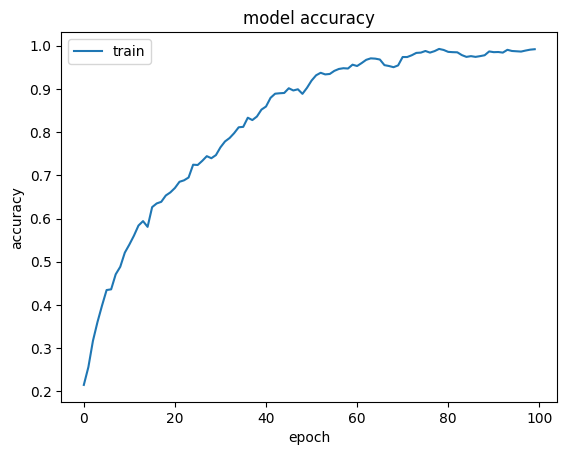

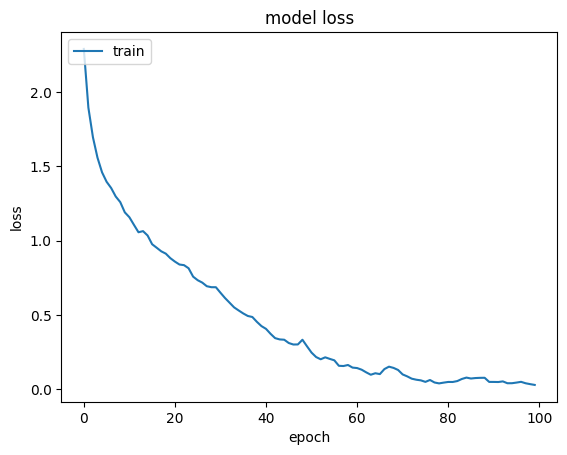

In [18]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()